The following code includes EDA and preprocessing for data from the Synthea database, a synthetic health record database. 

git clone https://github.com/synthetichealth/synthea.git
cd synthea

Save synthea-with-dependencies.jar from github to synthea folder on server

java -jar synthea-with-dependencies.jar

Generate csv files for self-harm in adult cases:
java -jar synthea-with-dependencies.jar -m self_harm -p 1000000 --exporter.csv.export true --exporter.subfolders_by_id_substring true

In [3]:
import numpy as np
import os
import pandas as pd
import json
import warnings

# Load the first data file
data_file1 = '/Users/SarahA/synthea/output/csv/encounters.csv'
df1 = pd.read_csv(data_file1)

# Load the second data file
data_file2 = '/Users/SarahA/synthea/output/csv/patients.csv'
df2 = pd.read_csv(data_file2)

# Merge the dataframes
merged_df = df1.merge(df2, left_on='PATIENT', right_on='Id', how='left')

# Save the merged dataframe to a new CSV file
merged_df.to_csv('merged_data.csv', index=False)

# Display column names, the first few rows, and the shape of the merged dataframe
print("Column Names:", merged_df.columns)
print("First Few Rows:", merged_df.head())
print("Dataframe Shape:", merged_df.shape)


/var/folders/dw/9kv692xj65d8csvjp0w67g740000gp/T/ipykernel_94526/4058713987.py:9: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(data_file1)
/var/folders/dw/9kv692xj65d8csvjp0w67g740000gp/T/ipykernel_94526/4058713987.py:13: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(data_file2)


Column Names: Index(['Id_x', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE', 'REASONDESCRIPTION',
       'Id_y', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT',
       'PREFIX', 'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE',
       'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE',
       'COUNTY', 'FIPS', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES',
       'HEALTHCARE_COVERAGE', 'INCOME'],
      dtype='object')
First Few Rows:                                    Id_x                 START  \
0  d9b6ff87-b38a-6dae-3f37-394800477d55  2015-11-19T22:42:43Z   
1  0a21e025-8edc-0378-2ea5-afdf4235ff2d  2016-04-19T18:07:10Z   
2  33525165-80ec-f52f-d786-ccfe83932b47  2019-04-23T18:07:10Z   
3  e34faee0-a3d4-ba50-ceff-9bdd7718a499  2021-11-02T18:07:10Z   
4  dd70104a-3415-b578-6ad9-92dafb2c0865  2018-11-22T22:42:43Z   



In [7]:

# Read the merged data from the CSV file
df = pd.read_csv('merged_data.csv')

# Create a subset of cases with non-empty "REASONDESCRIPTION"
subset_with_reason = df[df['REASONDESCRIPTION'].notna()]

# Get all cases with "REASONDESCRIPTION" data
cases_with_reason = subset_with_reason.sample(n=372, random_state=42)

# Calculate the number of additional cases needed
additional_cases_needed = 10000 - len(cases_with_reason)

# Create a random sample of additional cases from the remaining data
additional_cases = df.drop(cases_with_reason.index).sample(n=additional_cases_needed, random_state=42)

# Concatenate the two subsets to get the final 10,000 cases
final_df = pd.concat([cases_with_reason, additional_cases])

print("Final Dataframe Shape:", final_df.shape)


/var/folders/dw/9kv692xj65d8csvjp0w67g740000gp/T/ipykernel_94526/303358753.py:2: DtypeWarning: Columns (14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('merged_data.csv')


Final Dataframe Shape: (10000, 42)


In [10]:
df = final_df
#Examine the outcome of interest
print(df['REASONDESCRIPTION'].value_counts())

REASONDESCRIPTION
Suicidal deliberate poisoning      217
Attempted suicide - cut/stab        82
Attempted suicide - suffocation     65
Suicide - firearms                   5
Suicide - suffocation                3
Name: count, dtype: int64


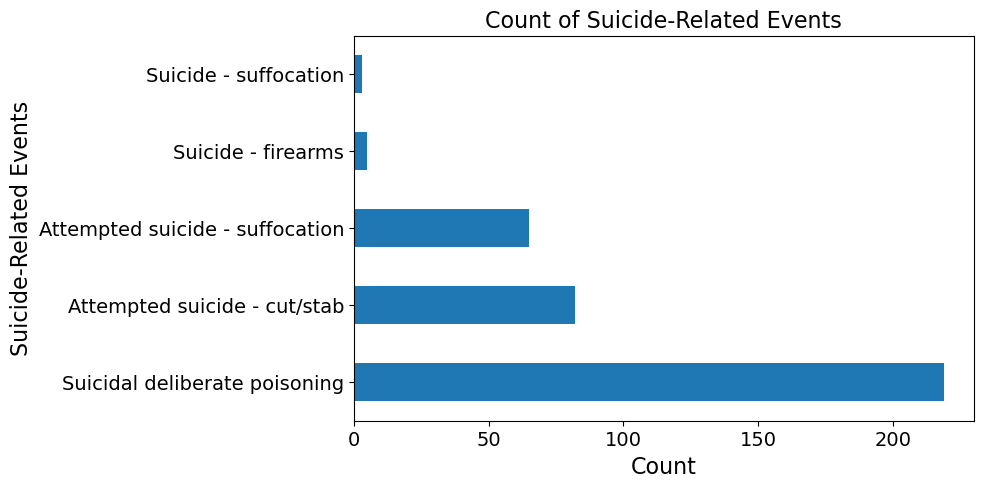

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a bar chart of suicide-related events
plt.figure(figsize=(8, 5)) 
pd.value_counts(df['REASONDESCRIPTION']).plot.barh()
plt.xlabel('Count', fontsize=16)
plt.ylabel('Suicide-Related Events', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Count of Suicide-Related Events', fontsize=16)
plt.show()

In [11]:
#Describe additional variables of interest
print(df['ENCOUNTERCLASS'].value_counts())
print(df['CODE'].value_counts())
print(df['DESCRIPTION'].value_counts())
print(df['PATIENT'].value_counts())

ENCOUNTERCLASS
wellness      8202
outpatient    1435
ambulatory     272
emergency       91
Name: count, dtype: int64
CODE
162673000    4982
410620009    3211
33879002     1435
185347001     272
50849002       91
308646001       9
Name: count, dtype: int64
DESCRIPTION
General examination of patient (procedure)                          4982
Well child visit (procedure)                                        3211
Administration of vaccine to produce active immunity (procedure)    1435
Encounter for problem                                                272
Emergency room admission (procedure)                                  91
Death Certification                                                    9
Name: count, dtype: int64
PATIENT
62acf06a-10ec-8618-6cbc-43bd47dca4f9    8
ffcdc461-88de-c6d9-bfba-0e3fb1d4d40d    6
f9a53f5e-880c-b04f-87dd-0be79ef6dccf    6
41ebdf61-ec0a-87bc-589d-966f7e7f0260    5
1e7a13b0-aac0-1bfa-36b6-35f29768f843    4
                                       ..
700331e9

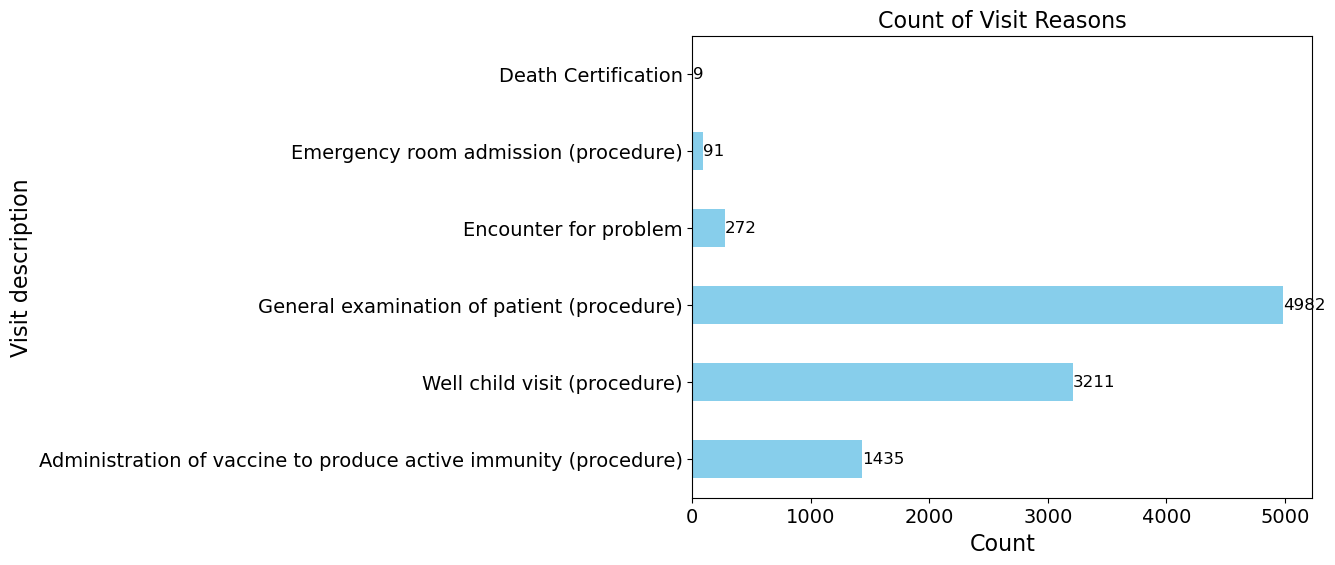

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

correct_order = ['Administration of vaccine to produce active immunity (procedure)', 'Well child visit (procedure)', 'General examination of patient (procedure)', 'Encounter for problem', 'Emergency room admission (procedure)', 'Death Certification']

# Calculate the value counts and reindex based on the correct order
value_counts = pd.value_counts(df['DESCRIPTION']).reindex(correct_order)

# Create a horizontal bar chart with log scale on the y-axis
plt.figure(figsize=(8, 6))
ax = value_counts.plot.barh(color='skyblue')

# Customize the plot

plt.xlabel('Count', fontsize=16)
plt.ylabel('Visit description', fontsize=16)
plt.title('Count of Visit Reasons', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label the bars with their values
for i, v in enumerate(value_counts):
    ax.text(v, i, str(v), va='center', fontsize=12)

plt.show()

In [28]:
count_matrix = df.groupby(['DESCRIPTION', 'REASONDESCRIPTION']).size().unstack()
print(count_matrix)

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
print(count_matrix_norm)

REASONDESCRIPTION                     Attempted suicide - cut/stab  \
DESCRIPTION                                                          
Death Certification                                            NaN   
Emergency room admission (procedure)                          16.0   
Encounter for problem                                         66.0   

REASONDESCRIPTION                     Attempted suicide - suffocation  \
DESCRIPTION                                                             
Death Certification                                               NaN   
Emergency room admission (procedure)                             15.0   
Encounter for problem                                            50.0   

REASONDESCRIPTION                     Suicidal deliberate poisoning  \
DESCRIPTION                                                           
Death Certification                                             1.0   
Emergency room admission (procedure)                           60.0   

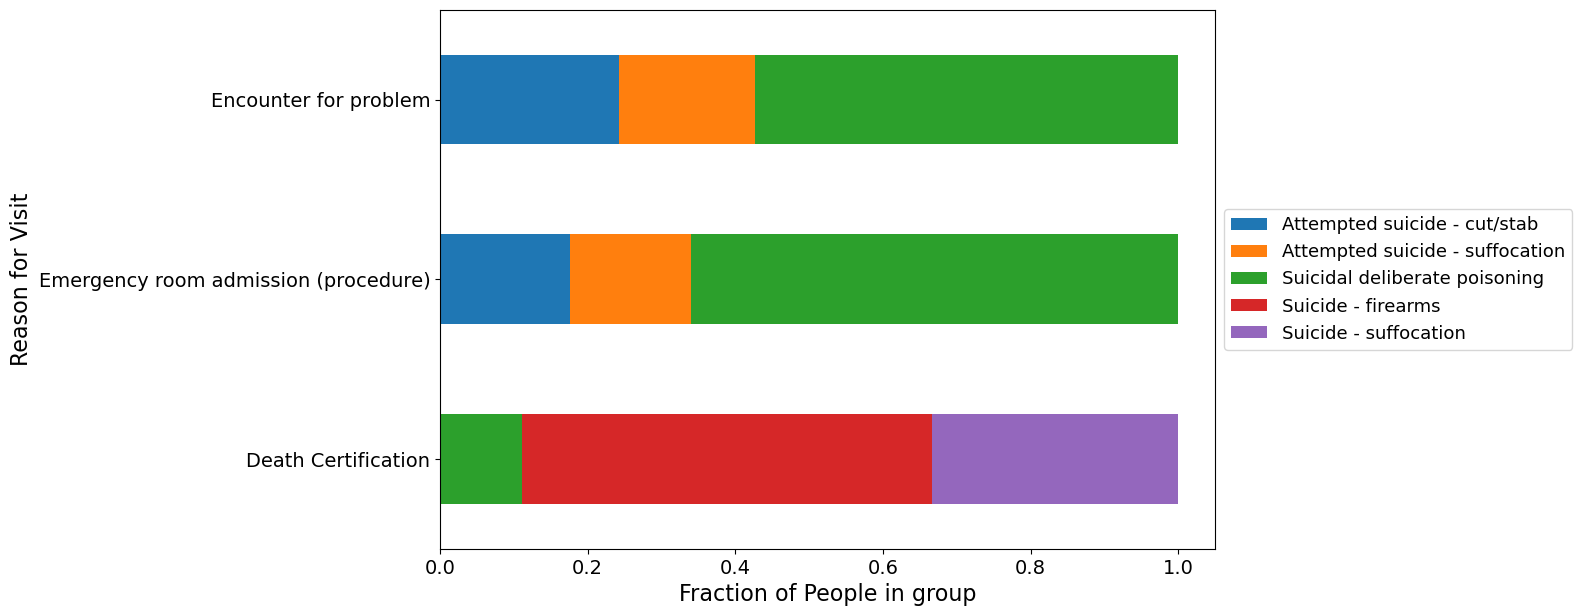

In [30]:
count_matrix_norm.plot(kind='barh', stacked=True, figsize=(10, 7))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=13)
plt.xlabel('Fraction of People in group', fontsize=16)
plt.ylabel('Reason for Visit', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [36]:
y = df['REASONCODE']
groups = df['PATIENT']
X = df.drop(columns=['PATIENT','REASONCODE'])
classes, counts = np.unique(y,return_counts=True)
print(classes, counts)
print('balance:',np.max(counts/len(y)))

[8.68490040e+07 2.87182007e+08 2.87185009e+08 2.87191006e+08
 2.87193009e+08            nan] [ 217   65   82    3    5 9628]
balance: 0.9628


In [37]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=5, train_size=.8, random_state=0)

for train_idx, test_idx in gss.split(X, y, groups):
    print("TRAIN:", train_idx, "TEST:", test_idx)

TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [   5   17   29 ... 9989 9993 9996]
TRAIN: [   0    1    2 ... 9996 9997 9998] TEST: [   3    6    9 ... 9975 9985 9999]
TRAIN: [   0    1    2 ... 9995 9997 9999] TEST: [   6    7   10 ... 9994 9996 9998]
TRAIN: [   0    1    4 ... 9997 9998 9999] TEST: [   2    3   11 ... 9978 9987 9992]
TRAIN: [   0    1    3 ... 9995 9996 9998] TEST: [   2   17   19 ... 9968 9997 9999]


In [40]:
# Define keywords related to suicide
suicide_keywords = ['suicide', 'self-harm', 'suicidal']

# Create a binary variable 'SuicideRelatedEvent'
df['SuicideRelatedEvent'] = df['REASONDESCRIPTION'].str.lower().str.contains('|'.join(suicide_keywords))

# Fill NaN values with 0 (assuming 0 indicates events that are not related to suicide)
df['SuicideRelatedEvent'] = df['SuicideRelatedEvent'].fillna(0).astype(int)

# Print the 'SuicideRelatedEvent' column
print(df['SuicideRelatedEvent'])


8308174    1
1067575    1
539075     1
8088740    1
1529764    1
          ..
6914306    0
8535072    0
7790720    0
6964163    0
5953959    0
Name: SuicideRelatedEvent, Length: 10000, dtype: int64


In [41]:
# Separate the feature matrix X, and target variable y
y = df['SuicideRelatedEvent'] # remember, we want to predict who has a suicide-related event
X = df.loc[:, df.columns != 'SuicideRelatedEvent'] # all other columns are features
print(y)
print(X.head())

8308174    1
1067575    1
539075     1
8088740    1
1529764    1
          ..
6914306    0
8535072    0
7790720    0
6964163    0
5953959    0
Name: SuicideRelatedEvent, Length: 10000, dtype: int64
                                         Id_x                 START  \
8308174  fffc96ed-550a-3a92-1e73-4c39f02512b0  2018-06-06T13:11:04Z   
1067575  17694587-69e3-6e55-ff44-58c7f9a8ec29  2009-02-10T05:21:02Z   
539075   7a57f7fd-66a8-4de4-7993-a346a64d9d31  2014-01-08T21:16:56Z   
8088740  688c1f3e-7b7c-c1c7-1cf1-24ef6e5dded1  2002-06-05T02:33:58Z   
1529764  ab42fe87-855c-4097-63f5-e60ae84a4cb9  1982-05-24T07:13:03Z   

                         STOP                               PATIENT  \
8308174  2018-06-08T06:12:04Z  106c3c84-32b6-5b26-7dba-880379448087   
1067575  2009-02-10T05:36:02Z  96f55e71-b625-d60e-7c76-d5c90f5a4c90   
539075   2014-01-09T23:39:56Z  48ea887e-12d3-d96a-e46b-1a96a29590b0   
8088740  2002-06-05T02:48:58Z  a3a60649-f4f0-1a2c-0fc7-37d621b9a24f   
1529764  1982-05-24T

In [44]:
from sklearn.model_selection import train_test_split
random_state = 42

# first split to separate out the training set
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=random_state)

# second split to separate out the validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=random_state)

print('training set')
print(X_train.head()) # lots of strings!
print(y_train.head()) # even our labels are strings and not numbers!

training set
                                         Id_x                 START  \
8117856  86eed4d3-5362-15d5-cfbc-4fb10b69be20  2021-11-23T19:54:22Z   
3231575  efceb0cc-c23a-b2db-f72f-7a25a5c76ef9  2021-04-06T20:46:36Z   
4436909  5dbb18cd-c53d-ad47-3972-f659492974f8  2015-05-20T09:45:13Z   
8735478  5595ac0e-4aa1-1912-6f3d-4e283d371f71  2015-07-15T10:41:49Z   
4085898  ae8aded1-0f23-0127-fb03-b1b7e327d367  2021-01-29T00:20:36Z   

                         STOP                               PATIENT  \
8117856  2021-11-23T20:09:22Z  e9c5e443-6cbd-88f7-8931-abc8e6ed63f9   
3231575  2021-04-06T21:01:36Z  572928be-59bf-4440-6043-1335ca20418e   
4436909  2015-05-20T10:00:13Z  624c5673-760b-1b8d-6f40-f82f2b5cff61   
8735478  2015-07-15T10:56:49Z  7b595e47-44df-a761-c959-ed59130d9b23   
4085898  2021-01-29T00:35:36Z  9a8e2431-cf19-85ae-df0e-c85e12dcf184   

                                 ORGANIZATION  \
8117856  b6eeaaf7-1683-3bcb-b6ee-81ce304636ef   
3231575  a5577e5c-b886-37a0-8eee-8f

In [57]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Specify categorical feature names to one-hot encode
onehot_ftrs = ['DESCRIPTION', 'ENCOUNTERCLASS', 'CODE', 'REASONDESCRIPTION', 'REASONCODE']

# Create a pipeline for one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# Define a preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, onehot_ftrs)
    ],
    remainder='passthrough'
)

# Create a pipeline with the preprocessor
clf = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform your data
X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

# Print the shapes and data
print("Original Data Shape:", X_train.shape)
print("Processed Data Shape:", X_train_prep.shape)
print("Processed Data:")
print(X_train_prep)


Original Data Shape: (6000, 42)
Processed Data Shape: (6000, 65)
Processed Data:
[[1.0 0.0 0.0 ... 10642.76 0.0 122359]
 [1.0 0.0 0.0 ... 14468.36 0.0 35789]
 [0.0 0.0 0.0 ... 7631.2 0.0 139555]
 ...
 [0.0 0.0 0.0 ... 6812.8 0.0 110929]
 [0.0 0.0 0.0 ... 10915.56 0.0 71638]
 [0.0 0.0 0.0 ... 4300.0 7153.6 10815]]


/Users/SarahA/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [51]:
perc_missing_per_ftr = df_train.isnull().sum(axis=0)/df_train.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df_train[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df_train.isnull().sum(axis=1)!=0)/df_train.shape[0]
print('fraction of points with missing values:',frac_missing)

fraction of missing values in features:
remainder__DEATHDATE    0.998667
remainder__DRIVERS      0.228833
remainder__PASSPORT     0.290167
remainder__PREFIX       0.259667
remainder__SUFFIX       0.989333
remainder__MAIDEN       0.732833
remainder__MARITAL      0.387667
remainder__FIPS         0.255833
dtype: float64
data types of the features with missing values:
remainder__DEATHDATE    object
remainder__DRIVERS      object
remainder__PASSPORT     object
remainder__PREFIX       object
remainder__SUFFIX       object
remainder__MAIDEN       object
remainder__MARITAL      object
remainder__FIPS         object
dtype: object
fraction of points with missing values: 1.0
